In [1]:
import sys
sys.path.insert(1, '/Users/Andrew/Documents/PhD/Scripts/Python/pygplates_rev12')
import pygplates
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpltools import style
from mpltools import layout
%matplotlib inline

/Users/Andrew/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/Andrew/anaconda/lib/python2.7/site-packages/mpltools/style/__init__.py:42: FutureWarning: 

    The style-sheet functionality in mpltools has been integrated into
    Matplotlib >= 1.4. This module will be removed in a future release.

    Note that style-sheets used by `matplotlib.style` use the standard
    Matplotlib rc-file syntax instead of the INI format used by `mpltools`.
    This mostly means un-quoting strings and changing '=' to ':'.


  """, FutureWarning)


In [2]:
#neoproterozoic model
rotation_model = pygplates.RotationModel('/Users/Andrew/Documents/PhD/Models/Rodinia_Models/Lis_model_amends/Merdith_Models/SWEAT_20151020/Rod-Gondw_Palaeozoic_20161212.rot')
features = pygplates.FeatureCollection('/Users/Andrew/Documents/PhD/Models/Rodinia_Models/Lis_model_amends/Merdith_Models/SWEAT_20151020/Rod-Gondw_intraplate_20161207.gpml')

In [3]:
centroids = []
plate_ids = []

for feature in features:
    polygon = feature.get_geometry()
    if polygon != None:
        plate = feature.get_reconstruction_plate_id()
        #print plate
        plate_ids.append(plate)
        point = polygon.get_boundary_centroid()
        centroid = point.to_lat_lon()
        centroids.append(centroid)

In [4]:
plate_ids_interest = [1001,
                      1002,
                      2201,
                      2202,
                      2203,
                      2204,
                      2206,
                      3001,
                      4001,
                      5501,
                      5503,
                      5504,
                      6001,
                      6601,
                      6603,
                      6604,
                      7701,
                      7702,
                      7703,
                      7704,
                      7705,
                      7706,
                      7709,
                      8001,
                      8004,
                      8802,
                      8803,
                      8804]

In [5]:
df = pd.DataFrame(
                {'plate_id': plate_ids,
                'centroid': centroids})

In [6]:
#df_sort = df.sort_values('plate_id')

In [7]:
df_filtered = df[df['plate_id'].isin(plate_ids_interest)]

In [8]:
df_filtered = df_filtered.drop(df_filtered.index[0])#important, this drops a specific duplicate entry of WAC (plate Id 7703)
#we want this entry out: 0 	((9.39841692392, -13.2217104832)) 	7703

In [9]:
df_filtered = df_filtered.drop(df_filtered.index[5])#important, this drops a specific duplicate entry of DML (plate Id 8802)
#we want this entry out: (-75.2590844224, -24.78883766)

In [10]:
df_filtered = df_filtered.drop(df_filtered.index[25]) #important, this drops a specific duplicate entry of India (plate Id 5501)
#we want this entry out: 33 	(29.9825715961, 72.0632608053) 	5501

In [11]:
df_filtered

centroid  plate_id
1     (18.294613658, -6.42629888816)      7703
2     (20.1533345607, 21.0175213244)      7705
5     (15.2298142138, 30.6339557794)      7706
6     (-4.8342460941, 22.7393067505)      7701
7    (-71.1604278477, 62.0811991908)      8804
9    (-75.0628796243, 127.099004605)      8803
10   (-73.3299555068, 10.1299395612)      8802
11    (57.4943413238, 34.8785575077)      3001
12      (31.2283786152, 113.4862926)      6603
13    (39.7147627505, 84.8544015198)      6604
14    (26.9442350473, 117.934270012)      6601
15    (38.6127006496, 117.777021372)      6001
16    (21.1586484847, 44.0011636191)      5503
17    (21.8212232265, 80.9468219952)      5501
19    (2.49549763774, 43.0448447072)      5504
20  (-33.2322753273, -58.5170706828)      2203
21  (-14.9849337741, -43.8794944365)      2204
22  (-2.01276715392, -62.1429576795)      2201
23  (-6.39328957616, -38.6556446546)      2206
26     (-27.6928073415, 127.3779713)      8004
27   (-18.6370271553, 134.192323002)      8001
28   (-24.2993381304, 25.4105076652)      7702
29    (22.8402904001, 6.77867814711)      7704
30  (-21.8590699465, -53.1770751863)      2202
32    (9.23631101838, 5.79830620551)      7709
36   (54.6863595432, -92.6803643388)      1001
37    (72.646485632, -42.6434280149)      1002
40     (62.8187210903, 114.06404075)      4001

In [12]:
SeedPoints = df_filtered['centroid'].tolist()
MovingPlates = df_filtered['plate_id'].tolist()
RelativePlate = 0
TimeStep = 5
times = np.arange(520,1000+TimeStep,TimeStep)

In [13]:
#create motion path features
digitisation_time = 0
seed_points_at_digitisation_time = []

for SeedPoint in SeedPoints:
    seed_points_at_digitisation_time.append(pygplates.MultiPointOnSphere([SeedPoint]))

In [14]:
motion_path_features = []

for i,j in zip(seed_points_at_digitisation_time,MovingPlates):
    #print i[0].to_lat_lon(),j
    motion_path_feature = pygplates.Feature.create_motion_path(i,
            times,
            valid_time=(1000, 0),
            relative_plate = RelativePlate,
            reconstruction_plate_id=j)
    
    motion_path_features.append(motion_path_feature)

In [15]:
# Create the shape of the motion path
reconstruction_time = 520
reconstructed_motion_paths = []

for motion_path_feature in motion_path_features:
    reconstructed_motion_path = pygplates.reconstruct(
            motion_path_feature, 
            rotation_model,
            reconstructed_motion_paths, 
            reconstruction_time,
            reconstruct_type=pygplates.ReconstructType.motion_path)

In [16]:
latitude_MP = []

for reconstructed_motion_path in reconstructed_motion_paths:
    plate_lat = []
#    # Print the motion path plate IDs.
#    print 'Motion path: %d relative to %d at %fMa' % (
#        reconstructed_motion_path.get_feature().get_reconstruction_plate_id(),
#        reconstructed_motion_path.get_feature().get_relative_plate(),
#        reconstruction_time)
#
#    # Print the reconstructed seed point location.
#    print '  reconstructed seed point: lat: %f, lon: %f' % reconstructed_motion_path.get_reconstructed_seed_point().to_lat_lon()
#
#    motion_path_times = reconstructed_motion_path.get_feature().get_times()
#
#    # Iterate over the points in the motion path.
    for point_index, point in enumerate(reconstructed_motion_path.get_motion_path()):

        lat, lon = point.to_lat_lon()
        plate_lat.append(lat)
        # The first point in the path is the oldest and the last point is the youngest.
        # So we need to start at the last time and work our way backwards.
        #time = motion_path_times[-1-point_index]
        
        # Print the point location and the time associated with it.
        #print '  time: %f, lat: %f, lon: %f' % (time, lat, lon)
    latitude_MP.append(plate_lat)

In [17]:
len(latitude_MP)

28

In [18]:
Dist = []
for reconstructed_motion_path in reconstructed_motion_paths:
    plate_dist = []
    #print reconstructed_motion_path
    for segment in reconstructed_motion_path.get_motion_path().get_segments():
        seg_dist = segment.get_arc_length()*pygplates.Earth.mean_radius_in_kms
        plate_dist.append(seg_dist)
    
    Dist.append(plate_dist)

In [19]:
Rate = np.asarray(Dist)/TimeStep

In [20]:
Rate_flip = []
for x in Rate:
    Rate1 = np.flipud(x)
    Rate_flip.append(Rate1)

In [21]:
Lat_flip = []
for y in latitude_MP:
    Lat1 = np.flipud(y)
    Lat_flip.append(Lat1)

In [22]:
Plate_Names = [
    'West Africa',
    'Sahara Metacraton',
    'Bayuda',
    'Congo',
    'Rayner',
    'Mawson',
    'Dronning Maud Land',
    'Baltica',
    'Yangtze (South China)',
    'Tarim',
    'Cathaysia (South China)',
    'North China',
    'Afif',
    'India',
    'Azania',
    'Rio de la Plata',
    'Sao Francisco',
    'Amazonia',
    'Borborema',
    'South Australia Craton',
    'North Australia Craton',
    'Kalahari',
    'Hoggar'
    'Parana',
    'Benin',
    'Laurentia',
    'Greenland',
    'Siberia'
    ]

In [23]:
colors = [
    '#ab523b',
    '#bc7462',
    '#b3634f',
    '#a34128',
    '#8a1242',
    '#942753',
    '#9f3d64',
    '#3e5641',
    '#dddc00',
    '#9e9962',
    '#b5b500',
    '#716d46',
    '#2cb6b9',
    '#52c3c5',
    '#3fbcbf',
    '#1f3c8b',
    '#334d95',
    '#1d377f',
    '#1a3272',
    '#a3157f',
    '#b33f96',
    '#8c4431',
    '#6d3526',
    '#16295e',
    '#6d3526',
    'k',
    '#b25740',
    '#7f7f7f'
    ]

/Users/Andrew/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


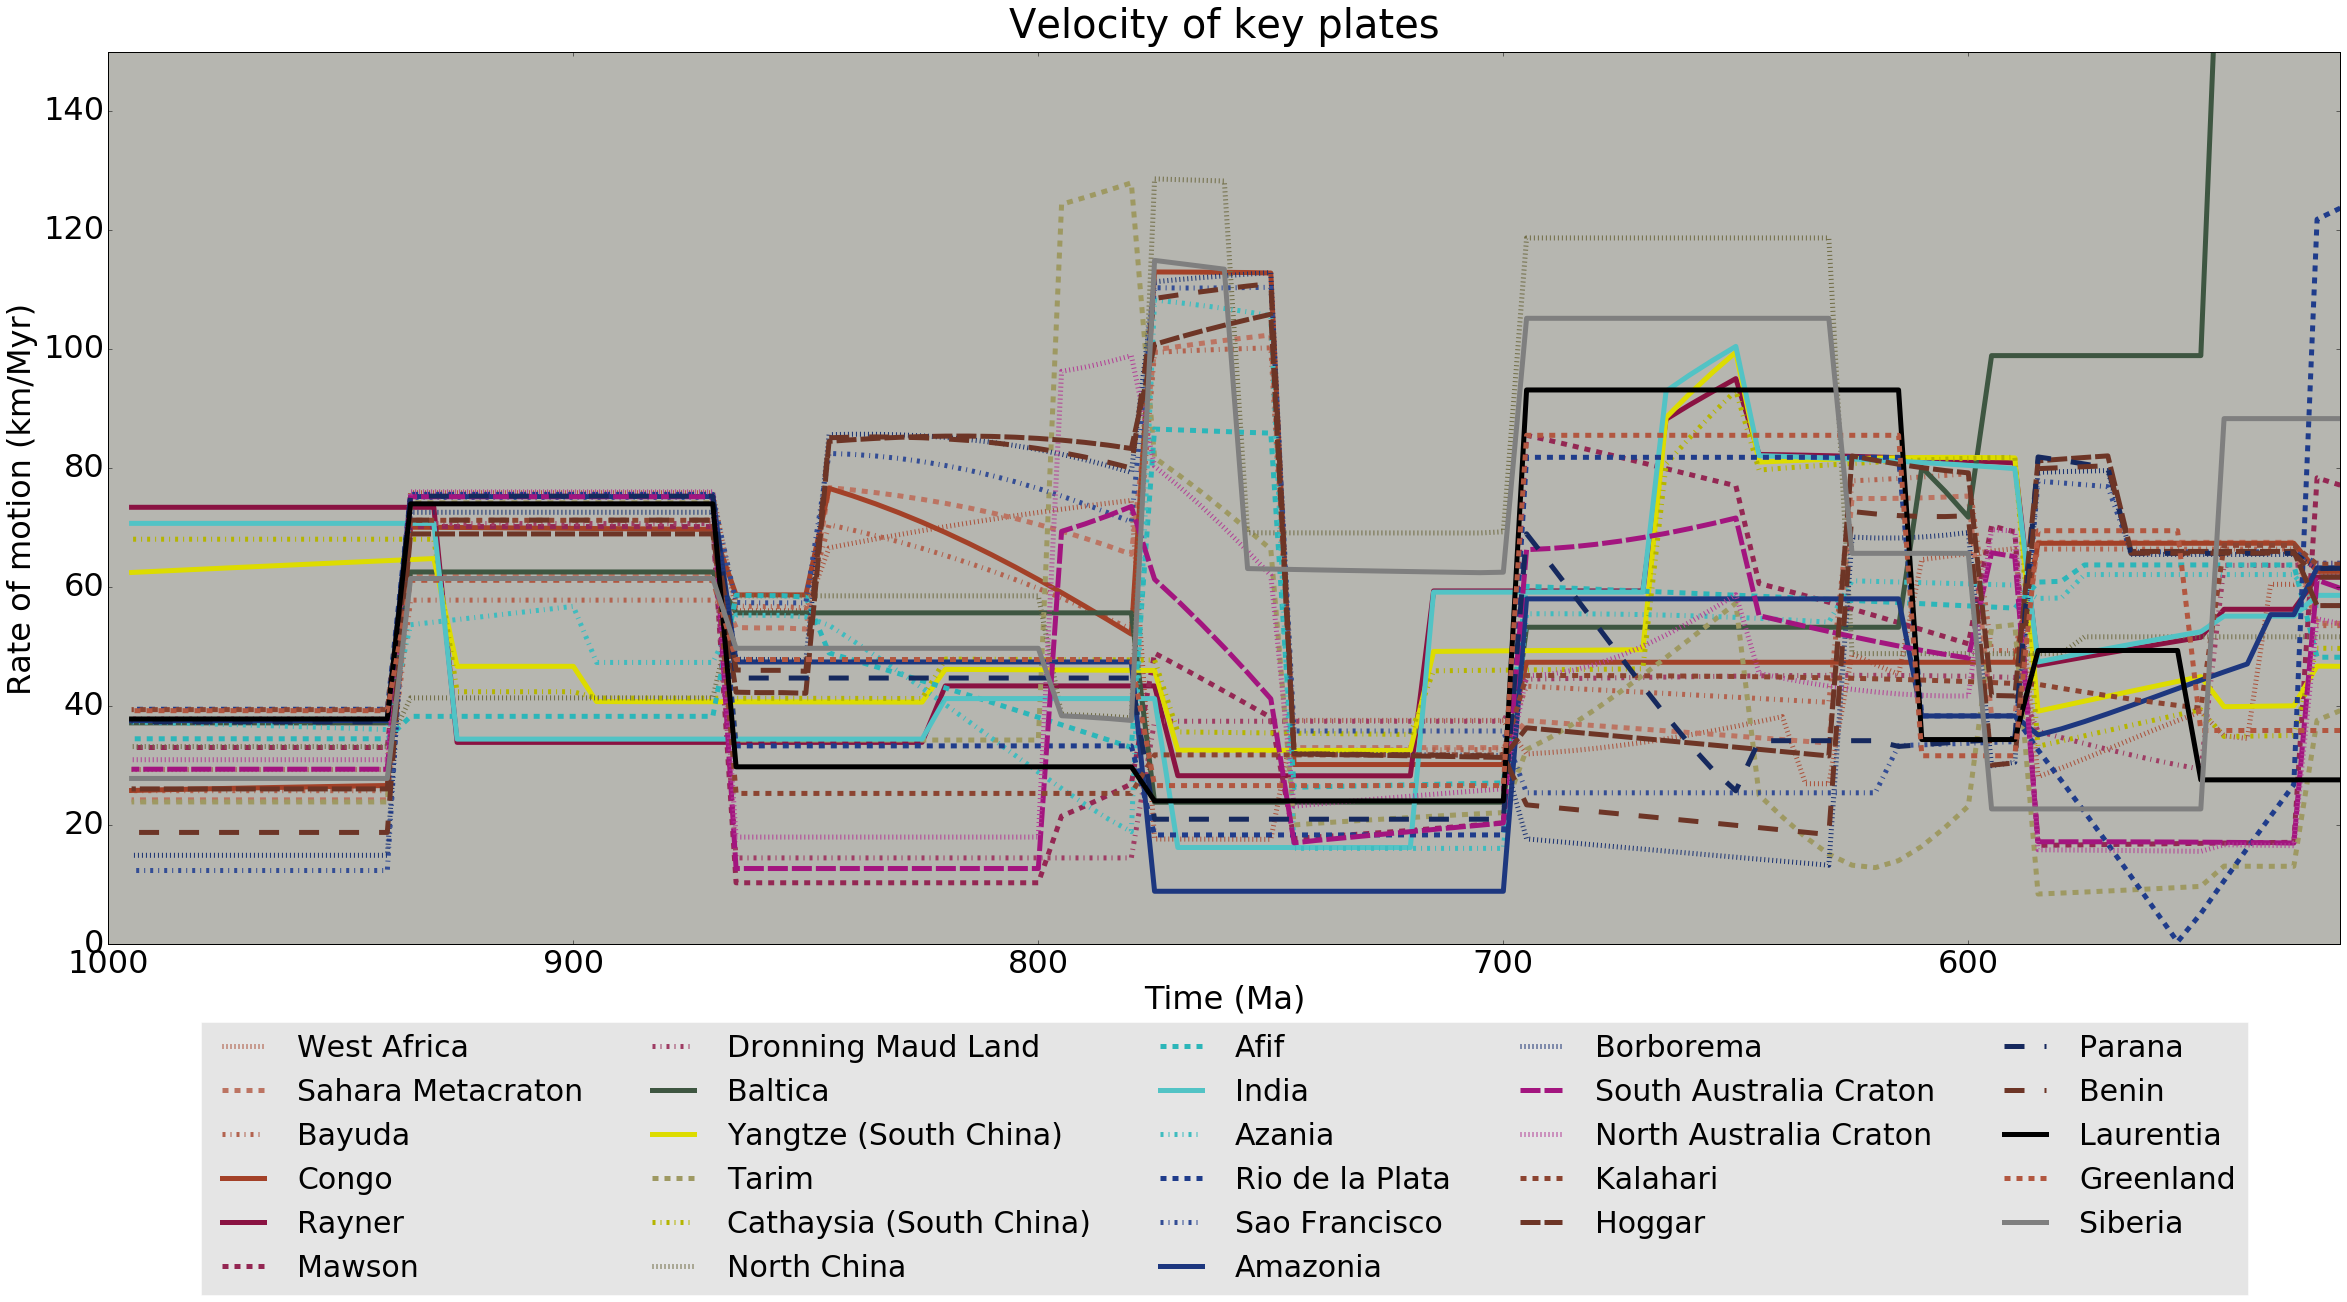

In [24]:
fig = plt.figure(figsize=(40,16),facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, axisbg='#b6b6b0')
style.use('ggplot')
ax.set(xlim=[1000,520], ylim=[0,150])
ax.plot(times[:-1],Rate_flip[0], color=colors[0], linewidth=5.0, linestyle=':', label='West Africa')
ax.plot(times[:-1],Rate_flip[1], color=colors[1], linewidth=5.0, linestyle='--',label='Sahara Metacraton')
ax.plot(times[:-1],Rate_flip[2], color=colors[2], linewidth=5.0, linestyle='-.',label='Bayuda')
ax.plot(times[:-1],Rate_flip[3], color=colors[3], linewidth=5.0, linestyle='-',label='Congo')
ax.plot(times[:-1],Rate_flip[4], color=colors[4], linewidth=5.0, linestyle='-',label='Rayner')
ax.plot(times[:-1],Rate_flip[5], color=colors[5], linewidth=5.0, linestyle='--', label='Mawson')
ax.plot(times[:-1],Rate_flip[6], color=colors[6], linewidth=5.0, linestyle='-.',label='Dronning Maud Land')
ax.plot(times[:-1],Rate_flip[7], color=colors[7], linewidth=5.0, linestyle='-',label='Baltica')
ax.plot(times[:-1],Rate_flip[8], color=colors[8], linewidth=5.0, linestyle='-',label='Yangtze (South China)')
ax.plot(times[:-1],Rate_flip[9], color=colors[9], linewidth=5.0, linestyle='--',label='Tarim')
ax.plot(times[:-1],Rate_flip[10], color=colors[10], linewidth=5.0, linestyle='-.',label='Cathaysia (South China)')
ax.plot(times[:-1],Rate_flip[11], color=colors[11], linewidth=5.0, linestyle=':', label='North China')
ax.plot(times[:-1],Rate_flip[12], color=colors[12], linewidth=5.0, linestyle='--', label='Afif')
ax.plot(times[:-1],Rate_flip[13], color=colors[13], linewidth=5.0, linestyle='-', label='India')
ax.plot(times[:-1],Rate_flip[14], color=colors[14], linewidth=5.0, linestyle='-.', label='Azania')
ax.plot(times[:-1],Rate_flip[15], color=colors[15], linewidth=5.0, linestyle='--', label='Rio de la Plata')
ax.plot(times[:-1],Rate_flip[16], color=colors[16], linewidth=5.0, linestyle='-.', label='Sao Francisco')
ax.plot(times[:-1],Rate_flip[17], color=colors[17], linewidth=5.0, linestyle='-', label='Amazonia')
ax.plot(times[:-1],Rate_flip[18], color=colors[18], linewidth=5.0, linestyle=':', label='Borborema')
ax.plot(times[:-1],Rate_flip[19], color=colors[19], linewidth=5.0, linestyle=(0, (20.0, 4.0)), label='South Australia Craton')
ax.plot(times[:-1],Rate_flip[20], color=colors[20], linewidth=5.0, linestyle=':', label='North Australia Craton')
ax.plot(times[:-1],Rate_flip[21], color=colors[21], linewidth=5.0, linestyle='--', label='Kalahari')
ax.plot(times[:-1],Rate_flip[22], color=colors[22], linewidth=5.0, linestyle=(0, (20.0, 4.0)), label='Hoggar')
ax.plot(times[:-1],Rate_flip[23], color=colors[23], linewidth=5.0, linestyle=(0, (20.0, 20.0)), label='Parana')
ax.plot(times[:-1],Rate_flip[24], color=colors[24], linewidth=5.0, linestyle=(0, (20.0, 20.0)), label='Benin')
ax.plot(times[:-1],Rate_flip[25], color=colors[25], linewidth=5.0, linestyle='-', label='Laurentia')
ax.plot(times[:-1],Rate_flip[26], color=colors[26], linewidth=5.0, linestyle='--', label='Greenland')
ax.plot(times[:-1],Rate_flip[27], color=colors[27], linewidth=5.0, linestyle='-', label='Siberia')
ax.set_xlabel('Time (Ma)', fontsize=32)
ax.set_ylabel('Rate of motion (km/Myr)', fontsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
ax.set_title('Velocity of key plates', fontsize=40, y=1.01)
ax.legend(fontsize=30,bbox_to_anchor=(0.5,-0.07), loc='upper center', ncol=5)#, mode='expand')
plt.show()


In [25]:
#figure params
linewidth=10
axes_title_fontsize = 60
tick_fontsize = 50
title_fontsize = 50
major_ticks = np.arange(-90, 91, 30) 
leg_font = 65

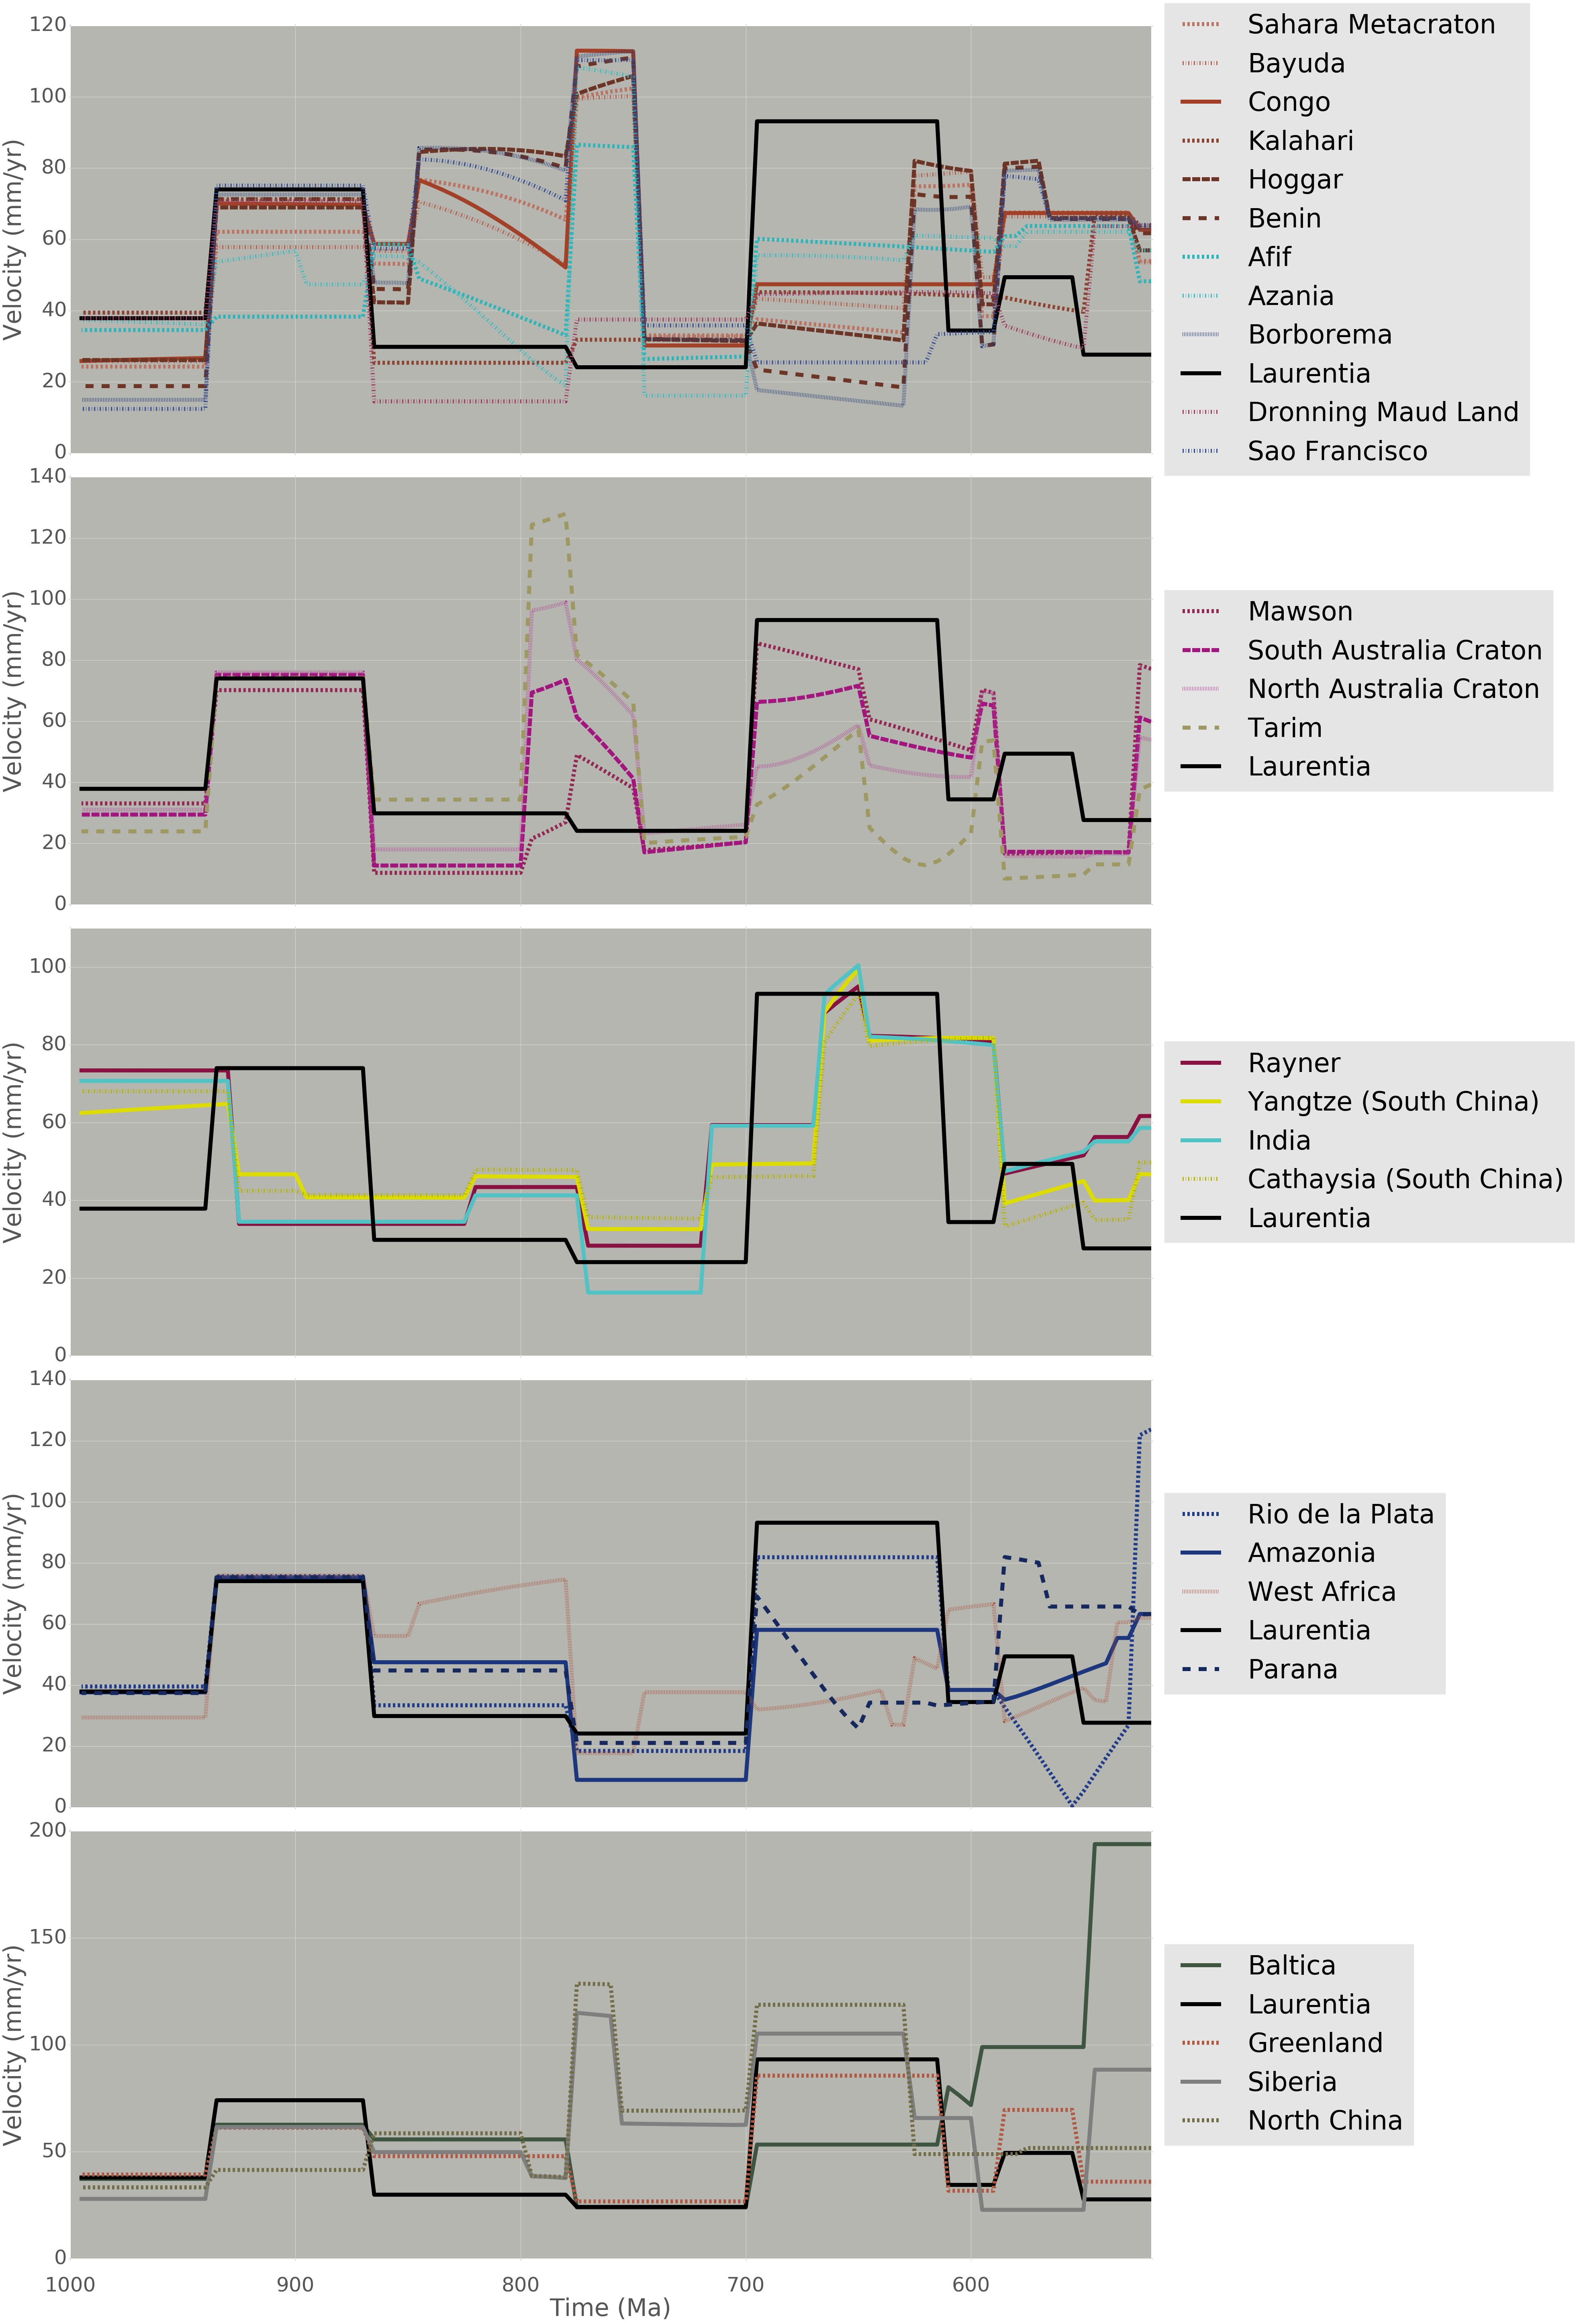

In [35]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(40,80),facecolor='w', edgecolor='k')


axes[0].plot(times[:-1],Rate_flip[1], color=colors[1], linewidth=linewidth, linestyle='--',label='Sahara Metacraton')
axes[0].plot(times[:-1],Rate_flip[2], color=colors[2], linewidth=linewidth, linestyle='-.',label='Bayuda')
axes[0].plot(times[:-1],Rate_flip[3], color=colors[3], linewidth=linewidth, linestyle='-',label='Congo')
axes[0].plot(times[:-1],Rate_flip[21], color=colors[21], linewidth=linewidth, linestyle='--', label='Kalahari')
axes[0].plot(times[:-1],Rate_flip[22], color=colors[22], linewidth=linewidth, linestyle=(0, (20.0, 4.0)), label='Hoggar')
axes[0].plot(times[:-1],Rate_flip[24], color=colors[24], linewidth=linewidth, linestyle=(0, (20.0, 20.0)), label='Benin')
axes[0].plot(times[:-1],Rate_flip[12], color=colors[12], linewidth=linewidth, linestyle='--', label='Afif')
axes[0].plot(times[:-1],Rate_flip[14], color=colors[14], linewidth=linewidth, linestyle='-.', label='Azania')
axes[0].plot(times[:-1],Rate_flip[18], color=colors[18], linewidth=linewidth, linestyle=':', label='Borborema')
axes[0].plot(times[:-1],Rate_flip[25], color=colors[25], linewidth=linewidth, linestyle='-', label='Laurentia')
axes[0].plot(times[:-1],Rate_flip[6], color=colors[6], linewidth=linewidth, linestyle='-.',label='Dronning Maud Land')
axes[0].plot(times[:-1],Rate_flip[16], color=colors[16], linewidth=linewidth, linestyle='-.', label='Sao Francisco')
axes[0].legend(fontsize=leg_font,bbox_to_anchor=(1,0.5), loc='center left', ncol=1)

axes[1].plot(times[:-1],Rate_flip[5], color=colors[5], linewidth=linewidth, linestyle='--', label='Mawson')
axes[1].plot(times[:-1],Rate_flip[19], color=colors[19], linewidth=linewidth, linestyle=(0, (20.0, 4.0)), label='South Australia Craton')
axes[1].plot(times[:-1],Rate_flip[20], color=colors[20], linewidth=linewidth, linestyle=':', label='North Australia Craton')
axes[1].plot(times[:-1],Rate_flip[9], color=colors[9], linewidth=linewidth, linestyle=(0, (20.0, 20.0)),label='Tarim')
axes[1].plot(times[:-1],Rate_flip[25], color=colors[25], linewidth=linewidth, linestyle='-', label='Laurentia')
axes[1].legend(fontsize=leg_font,bbox_to_anchor=(1,0.5), loc='center left', ncol=1)

axes[2].plot(times[:-1],Rate_flip[4], color=colors[4], linewidth=linewidth, linestyle='-',label='Rayner')
axes[2].plot(times[:-1],Rate_flip[8], color=colors[8], linewidth=linewidth, linestyle='-',label='Yangtze (South China)')
axes[2].plot(times[:-1],Rate_flip[13], color=colors[13], linewidth=linewidth, linestyle='-', label='India')
axes[2].plot(times[:-1],Rate_flip[10], color=colors[10], linewidth=linewidth, linestyle='-.',label='Cathaysia (South China)')
axes[2].plot(times[:-1],Rate_flip[25], color=colors[25], linewidth=linewidth, linestyle='-', label='Laurentia')
axes[2].legend(fontsize=leg_font,bbox_to_anchor=(1,0.5), loc='center left', ncol=1)

axes[3].plot(times[:-1],Rate_flip[15], color=colors[15], linewidth=linewidth, linestyle='--', label='Rio de la Plata')
axes[3].plot(times[:-1],Rate_flip[17], color=colors[17], linewidth=linewidth, linestyle='-', label='Amazonia')
axes[3].plot(times[:-1],Rate_flip[0], color=colors[0], linewidth=linewidth, linestyle=':', label='West Africa')
axes[3].plot(times[:-1],Rate_flip[25], color=colors[25], linewidth=linewidth, linestyle='-', label='Laurentia')
axes[3].plot(times[:-1],Rate_flip[23], color=colors[23], linewidth=linewidth, linestyle=(0, (20.0, 20.0)), label='Parana')
axes[3].legend(fontsize=leg_font,bbox_to_anchor=(1,0.5), loc='center left', ncol=1)

axes[4].plot(times[:-1],Rate_flip[7], color=colors[7], linewidth=linewidth, linestyle='-',label='Baltica')
axes[4].plot(times[:-1],Rate_flip[25], color=colors[25], linewidth=linewidth, linestyle='-', label='Laurentia')
axes[4].plot(times[:-1],Rate_flip[26], color=colors[26], linewidth=linewidth, linestyle='--', label='Greenland')
axes[4].plot(times[:-1],Rate_flip[27], color=colors[27], linewidth=linewidth, linestyle='-', label='Siberia')
axes[4].plot(times[:-1],Rate_flip[11], color=colors[11], linewidth=linewidth, linestyle='--', label='North China')
axes[4].legend(fontsize=leg_font,bbox_to_anchor=(1,0.5), loc='center left', ncol=1)

for i in range(5):
    axes[i].set_ylabel('Velocity (mm/yr)', fontsize=axes_title_fontsize)
    axes[i].set(xlim=[1000,520])#, ylim=[0,200])
    axes[i].set_ylim(bottom=0)
    axes[i].tick_params(axis='y', labelsize=tick_fontsize)
    axes[i].set_axis_bgcolor('#b6b6b0')
    axes[i].grid(True)
for i in range(4):
    axes[i].set_xticklabels([])
axes[4].set_xlabel('Time (Ma)', fontsize=axes_title_fontsize)
axes[4].tick_params(axis='x', labelsize=tick_fontsize, pad=40)
plt.tight_layout()
plt.savefig('Velocity.svg', bbox_inches='tight')

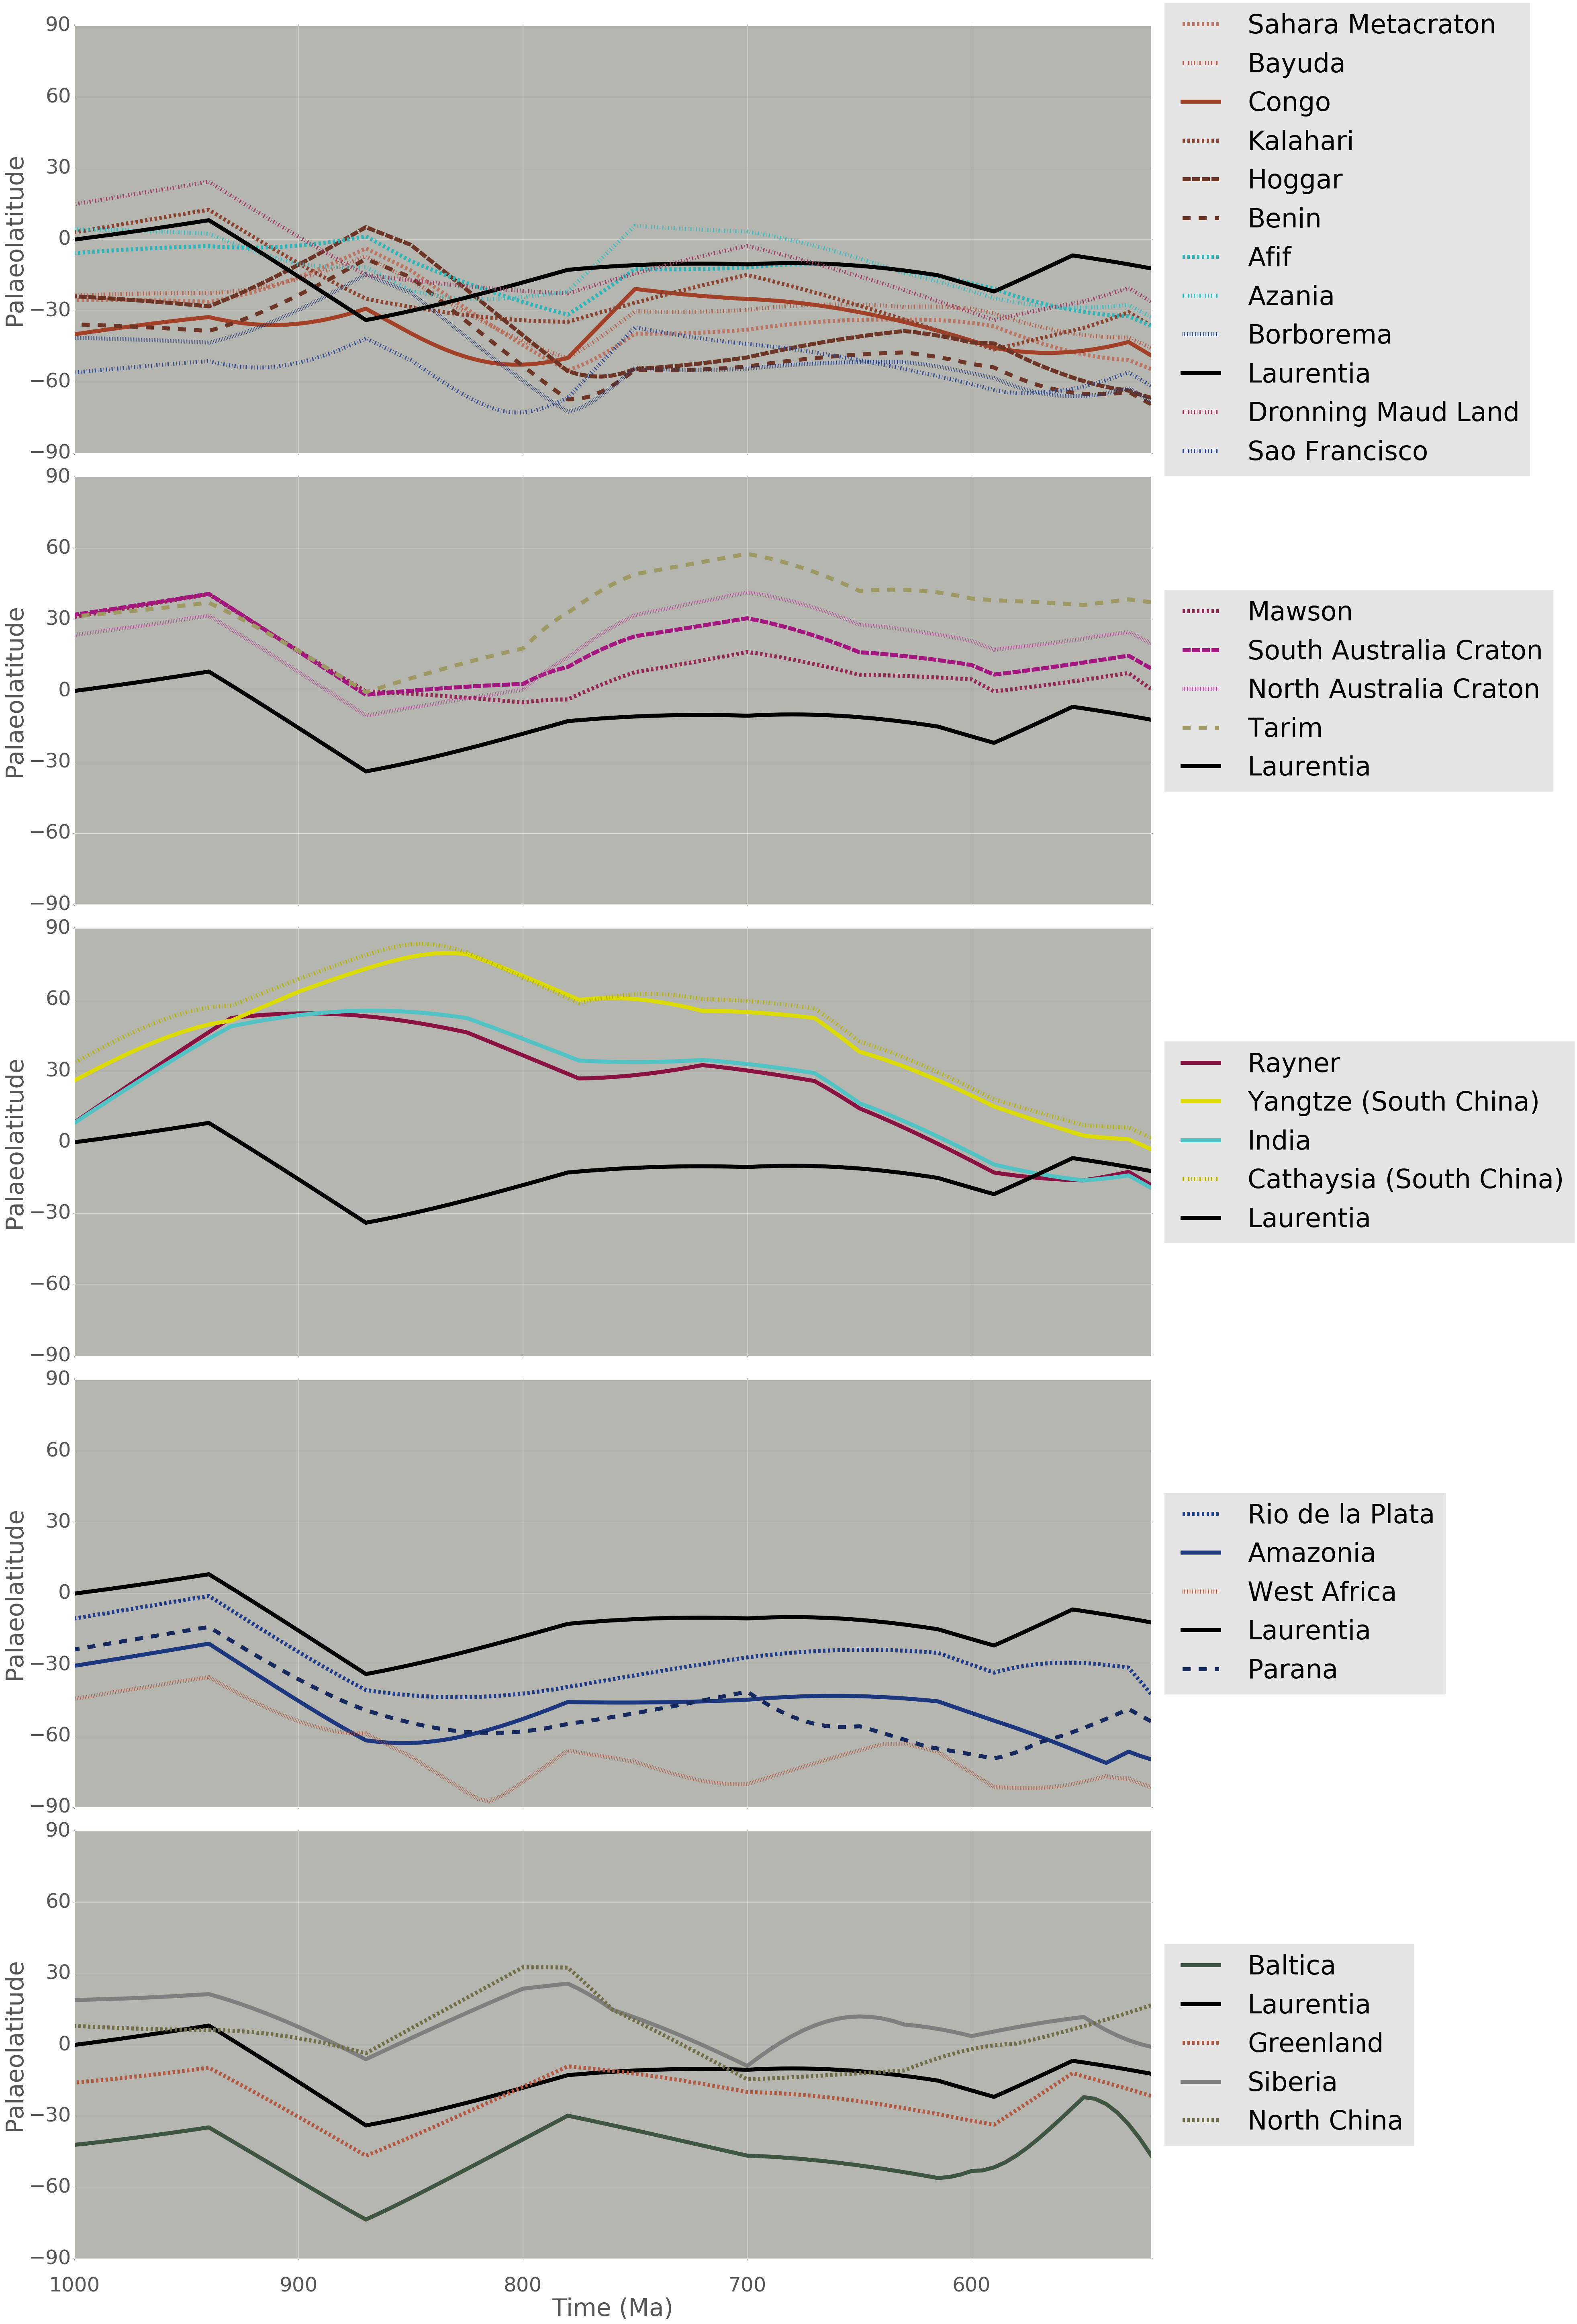

In [34]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(40,80),facecolor='w', edgecolor='k')


axes[0].plot(times,Lat_flip[1], color=colors[1], linewidth=linewidth, linestyle='--',label='Sahara Metacraton')
axes[0].plot(times,Lat_flip[2], color=colors[2], linewidth=linewidth, linestyle='-.',label='Bayuda')
axes[0].plot(times,Lat_flip[3], color=colors[3], linewidth=linewidth, linestyle='-',label='Congo')
axes[0].plot(times,Lat_flip[21], color=colors[21], linewidth=linewidth, linestyle='--', label='Kalahari')
axes[0].plot(times,Lat_flip[22], color=colors[22], linewidth=linewidth, linestyle=(0, (20.0, 4.0)), label='Hoggar')
axes[0].plot(times,Lat_flip[24], color=colors[24], linewidth=linewidth, linestyle=(0, (20.0, 20.0)), label='Benin')
axes[0].plot(times,Lat_flip[12], color=colors[12], linewidth=linewidth, linestyle='--', label='Afif')
axes[0].plot(times,Lat_flip[14], color=colors[14], linewidth=linewidth, linestyle='-.', label='Azania')
axes[0].plot(times,Lat_flip[18], color=colors[18], linewidth=linewidth, linestyle=':', label='Borborema')
axes[0].plot(times,Lat_flip[25], color=colors[25], linewidth=linewidth, linestyle='-', label='Laurentia')
axes[0].plot(times,Lat_flip[6], color=colors[6], linewidth=linewidth, linestyle='-.',label='Dronning Maud Land')
axes[0].plot(times,Lat_flip[16], color=colors[16], linewidth=linewidth, linestyle='-.', label='Sao Francisco')
axes[0].legend(fontsize=leg_font,bbox_to_anchor=(1,0.5), loc='center left', ncol=1)

axes[1].plot(times,Lat_flip[5], color=colors[5], linewidth=linewidth, linestyle='--', label='Mawson')
axes[1].plot(times,Lat_flip[19], color=colors[19], linewidth=linewidth, linestyle=(0, (20.0, 4.0)), label='South Australia Craton')
axes[1].plot(times,Lat_flip[20], color=colors[20], linewidth=linewidth, linestyle=':', label='North Australia Craton')
axes[1].plot(times,Lat_flip[9], color=colors[9], linewidth=linewidth, linestyle=(0, (20.0, 20.0)),label='Tarim')
axes[1].plot(times,Lat_flip[25], color=colors[25], linewidth=linewidth, linestyle='-', label='Laurentia')
axes[1].legend(fontsize=leg_font,bbox_to_anchor=(1,0.5), loc='center left', ncol=1)

axes[2].plot(times,Lat_flip[4], color=colors[4], linewidth=linewidth, linestyle='-',label='Rayner')
axes[2].plot(times,Lat_flip[8], color=colors[8], linewidth=linewidth, linestyle='-',label='Yangtze (South China)')
axes[2].plot(times,Lat_flip[13], color=colors[13], linewidth=linewidth, linestyle='-', label='India')
axes[2].plot(times,Lat_flip[10], color=colors[10], linewidth=linewidth, linestyle='-.',label='Cathaysia (South China)')
axes[2].plot(times,Lat_flip[25], color=colors[25], linewidth=linewidth, linestyle='-', label='Laurentia')
axes[2].legend(fontsize=leg_font,bbox_to_anchor=(1,0.5), loc='center left', ncol=1)

axes[3].plot(times,Lat_flip[15], color=colors[15], linewidth=linewidth, linestyle='--', label='Rio de la Plata')
axes[3].plot(times,Lat_flip[17], color=colors[17], linewidth=linewidth, linestyle='-', label='Amazonia')
axes[3].plot(times,Lat_flip[0], color=colors[0], linewidth=linewidth, linestyle=':', label='West Africa')
axes[3].plot(times,Lat_flip[25], color=colors[25], linewidth=linewidth, linestyle='-', label='Laurentia')
axes[3].plot(times,Lat_flip[23], color=colors[23], linewidth=linewidth, linestyle=(0, (20.0, 20.0)), label='Parana')
axes[3].legend(fontsize=leg_font,bbox_to_anchor=(1,0.5), loc='center left', ncol=1)

axes[4].plot(times,Lat_flip[7], color=colors[7], linewidth=linewidth, linestyle='-',label='Baltica')
axes[4].plot(times,Lat_flip[25], color=colors[25], linewidth=linewidth, linestyle='-', label='Laurentia')
axes[4].plot(times,Lat_flip[26], color=colors[26], linewidth=linewidth, linestyle='--', label='Greenland')
axes[4].plot(times,Lat_flip[27], color=colors[27], linewidth=linewidth, linestyle='-', label='Siberia')
axes[4].plot(times,Lat_flip[11], color=colors[11], linewidth=linewidth, linestyle='--', label='North China')
axes[4].legend(fontsize=leg_font,bbox_to_anchor=(1,0.5), loc='center left', ncol=1)

for i in range(5):
    axes[i].set_ylabel('Palaeolatitude', fontsize=axes_title_fontsize)
    axes[i].set_yticks(major_ticks)
    axes[i].set(xlim=[1000,520], ylim=[-90,90])
    axes[i].tick_params(axis='y', labelsize=tick_fontsize)
    axes[i].set_axis_bgcolor('#b6b6b0')
    axes[i].grid(True)
for i in range(4):
    axes[i].set_xticklabels([])
axes[4].set_xlabel('Time (Ma)', fontsize=axes_title_fontsize)
axes[4].tick_params(axis='x', labelsize=tick_fontsize, pad=40)
plt.tight_layout()
plt.savefig('Palaeolatitude.svg', bbox_inches='tight')